In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pypoman
import scipy.spatial
import polytope
import torch

import pynever.strategies.abstraction as abst
import pynever.nodes as nodes
import pynever.strategies.verification as ver
import pynever.networks as networks
import pynever.utilities as utils
import pynever.strategies.conversion as conv


def plot_star(p_star: abst.Star, show=False, title=None, color = np.array([0.5, 0.5, 1])):

    #color = np.random.rand(3)
    alpha_vertexes = pypoman.compute_polytope_vertices(p_star.predicate_matrix, p_star.predicate_bias)
    x_vertexes = []
    for v in alpha_vertexes:
        v_ver = np.zeros((v.shape[0], 1))
        for k in range(v.shape[0]):
            v_ver[k, 0] = v[k]
        new_x_v = p_star.center + np.matmul(p_star.basis_matrix, v_ver)
        x_vertexes.append(new_x_v)

    x1_plot = []
    x2_plot = []
    for v in x_vertexes:
        x1_plot.append(v[0, 0])
        x2_plot.append(v[1, 0])

    for k in range(len(x1_plot)):
        for j in range(len(x1_plot)):
            plt.plot([x1_plot[k], x1_plot[j]], [x2_plot[k], x2_plot[j]], color=color)

    plt.scatter(x1_plot, x2_plot, color=color)
    if show:
        if title is not None:
            plt.title(title)
        plt.grid()


def plot_starset(p_starset: abst.StarSet, title, color = np.array([0.5, 0.5, 1])):
    for p_star in p_starset.stars:

        plot_star(p_star, color=color)

    if title is not None:
        plt.title(title)
    plt.grid()


def get_star_extreme_points(p_star: abst.Star):

    x_vertexes = []
    alpha_vertexes = pypoman.compute_polytope_vertices(p_star.predicate_matrix, p_star.predicate_bias)
    for v in alpha_vertexes:
        v_ver = np.zeros((v.shape[0], 1))
        for k in range(v.shape[0]):
            v_ver[k, 0] = v[k]
        new_x_v = p_star.center + np.matmul(p_star.basis_matrix, v_ver)
        new_x_v = np.array([new_x_v[0, 0], new_x_v[1, 0]])
        x_vertexes.append(new_x_v)

    x_vertexes = np.array(x_vertexes)

    return x_vertexes

def get_starset_extreme_points(p_starset: abst.StarSet):
    x_vertexes = []
    for p_star in p_starset.stars:
        alpha_vertexes = pypoman.compute_polytope_vertices(p_star.predicate_matrix, p_star.predicate_bias)
        for v in alpha_vertexes:
            v_ver = np.zeros((v.shape[0], 1))
            for k in range(v.shape[0]):
                v_ver[k, 0] = v[k]
            new_x_v = p_star.center + np.matmul(p_star.basis_matrix, v_ver)
            new_x_v = np.array([new_x_v[0, 0], new_x_v[1, 0]])
            x_vertexes.append(new_x_v)

    x_vertexes = np.array(x_vertexes)
    return x_vertexes


def plot_convex_hull(points: np.ndarray, title = None, color=None, alpha=1, label=None):

    hull = scipy.spatial.ConvexHull(points)
    vertexes = points[hull.vertices, :]
    vertexes = np.vstack((vertexes, vertexes[0, :]))
    if color is None:
        plt.fill(vertexes[:, 0], vertexes[:, 1], alpha=0.5, label=label)
    else:
        plt.fill(vertexes[:, 0], vertexes[:, 1], color=color, alpha=alpha, label=label)
    
    if title is not None:
        plt.title(title)
    plt.grid()


def print_star_data(p_star: abst.Star):

    print("PREDICATE CONSTRAINTS:")
    for row in range(p_star.predicate_matrix.shape[0]):
        constraint = ""
        for col in range(p_star.predicate_matrix.shape[1]):
            if p_star.predicate_matrix[row, col] < 0:
                sign = "-"
            else:
                sign = "+"
            constraint = constraint + f"{sign} {abs(p_star.predicate_matrix[row, col])} * x_{col} "

        constraint = constraint + f"<= {p_star.predicate_bias[row, 0]}"
        print(constraint)

    print("VARIABLES EQUATIONS:")
    for row in range(p_star.basis_matrix.shape[0]):
        equation = f"z_{row} = "
        for col in range(p_star.basis_matrix.shape[1]):
            if p_star.basis_matrix[row, col] < 0:
                sign = "-"
            else:
                sign = "+"
            equation = equation + f"{sign} {abs(p_star.basis_matrix[row, col])} * x_{col} "

        if p_star.center[row, 0] < 0:
            c_sign = "-"
        else:
            c_sign = "+"
        equation = equation + f"{c_sign} {abs(p_star.center[row, 0])}"
        print(equation)

INPUT STARS


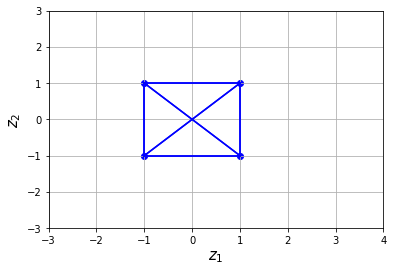

PREDICATE CONSTRAINTS:
+ 1.0 * x_0 + 0.0 * x_1 <= 1.0
- 1.0 * x_0 + 0.0 * x_1 <= 1.0
+ 0.0 * x_0 + 1.0 * x_1 <= 1.0
+ 0.0 * x_0 - 1.0 * x_1 <= 1.0
VARIABLES EQUATIONS:
z_0 = + 1.0 * x_0 + 0.0 * x_1 + 0.0
z_1 = + 0.0 * x_0 + 1.0 * x_1 + 0.0

INPUT STARSET


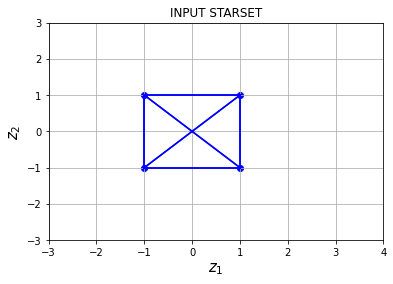

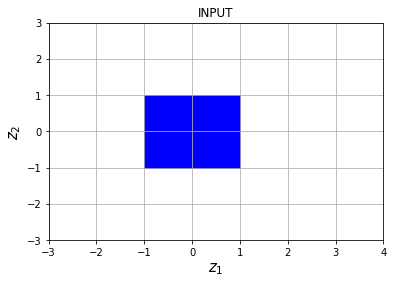

In [2]:
fill_color = 'blue'
final_abstract_hulls = []


# VERIFICATION METHODOLOGY CONTROL
n_ref_n = 10

# INPUT STARSET DEFINITION
C = np.zeros((4, 2))
C[0, 0] = 1
C[1, 0] = -1
C[2, 1] = 1
C[3, 1] = -1

d = np.ones((4, 1))
d[0, 0] = 1
d[1, 0] = 1
d[2, 0] = 1
d[3, 0] = 1

star = abst.Star(C, d)
abs_input = abst.StarSet({star})

# INPUT STAR VISUALIZATION
print("INPUT STARS")
for star in abs_input.stars:
    plot_star(star, show=True, color=fill_color)
    plt.xlabel("$z_1$", size=15)
    plt.ylabel("$z_2$", size=15)
    plt.xlim([-3,4])
    plt.ylim([-3,3])
    plt.show()
    print_star_data(star)

print("\nINPUT STARSET")
plot_starset(abs_input, "INPUT STARSET", color=fill_color)
plt.xlabel("$z_1$", size=15)
plt.ylabel("$z_2$", size=15)
plt.xlim([-3,4])
plt.ylim([-3,3])
plt.show()
plot_convex_hull(get_starset_extreme_points(abs_input), "INPUT", color=fill_color)
plt.xlim([-3,4])
plt.ylim([-3,3])
plt.xlabel("$z_1$", size=15)
plt.ylabel("$z_2$", size=15)
plt.savefig("complete_input.pdf")
plt.show()



CURRENT NODE: AbsFC_1
WEIGHTS: [[ 1.  1.]
 [ 1. -1.]]
BIAS: [0. 0.]

STARS


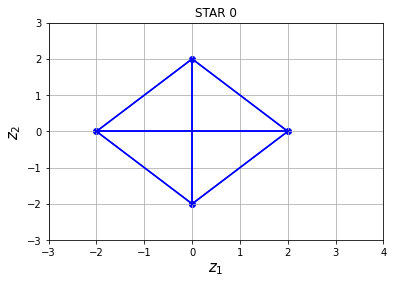

PREDICATE CONSTRAINTS:
+ 1.0 * x_0 + 0.0 * x_1 <= 1.0
- 1.0 * x_0 + 0.0 * x_1 <= 1.0
+ 0.0 * x_0 + 1.0 * x_1 <= 1.0
+ 0.0 * x_0 - 1.0 * x_1 <= 1.0
VARIABLES EQUATIONS:
z_0 = + 1.0 * x_0 + 1.0 * x_1 + 0.0
z_1 = + 1.0 * x_0 - 1.0 * x_1 + 0.0

STARSET


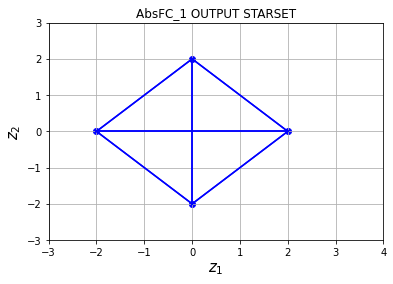

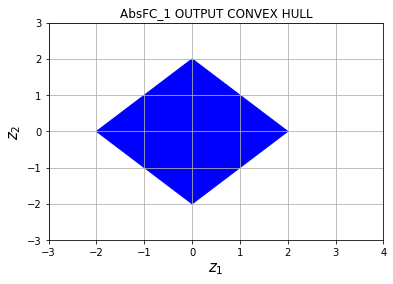

In [3]:
# FIRST FULLY CONNECTED NODE DEFINITION

weight_matrix_1 = np.ones((2, 2))
weight_matrix_1[1, 1] = -1
bias_1 = np.zeros(2)
current_node = abst.AbsFullyConnectedNode("AbsFC_1", nodes.FullyConnectedNode("FC_1", (2,), 2, weight_matrix_1, bias_1))

# CORRESPONDING ABSTRACT OUTPUT COMPUTATION
abs_input = current_node.forward(abs_input)

# NODE VISUALIZATION
print(f"\n\nCURRENT NODE: {current_node.identifier}")
print(f"WEIGHTS: {current_node.ref_node.weight}")
print(f"BIAS: {current_node.ref_node.bias}")

# STARS AND STARSET VISUALIZATION
print("\nSTARS")
n_star = 0
for star in abs_input.stars:
    plot_star(star, show=True, title=f"STAR {n_star}", color=fill_color)
    plt.xlim([-3,4])
    plt.ylim([-3,3])
    plt.xlabel("$z_1$", size=15)
    plt.ylabel("$z_2$", size=15)
    plt.savefig(f"overapproximate_{current_node.identifier}_STAR={n_star}.pdf")
    plt.show()
    print_star_data(star)
    n_star += 1

print("\nSTARSET")
plot_starset(abs_input, current_node.identifier + " OUTPUT STARSET", color=fill_color)
plt.xlim([-3,4])
plt.ylim([-3,3])
plt.xlabel("$z_1$", size=15)
plt.ylabel("$z_2$", size=15)
plt.show()
plot_convex_hull(get_starset_extreme_points(abs_input), 
                 current_node.identifier + " OUTPUT CONVEX HULL", color=fill_color)
plt.xlim([-3,4])
plt.ylim([-3,3])
plt.xlabel("$z_1$", size=15)
plt.ylabel("$z_2$", size=15)
plt.savefig(f"overapproximate_chull_{current_node.identifier}.pdf")
plt.show()
final_abstract_hulls.append(get_starset_extreme_points(abs_input))



CURRENT NODE: AbsReLU_1

STARS


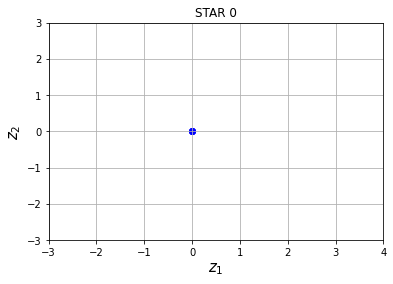

PREDICATE CONSTRAINTS:
+ 1.0 * x_0 + 0.0 * x_1 <= 1.0
- 1.0 * x_0 + 0.0 * x_1 <= 1.0
+ 0.0 * x_0 + 1.0 * x_1 <= 1.0
+ 0.0 * x_0 - 1.0 * x_1 <= 1.0
+ 1.0 * x_0 + 1.0 * x_1 <= -0.0
+ 1.0 * x_0 - 1.0 * x_1 <= -0.0
VARIABLES EQUATIONS:
z_0 = + 0.0 * x_0 + 0.0 * x_1 + 0.0
z_1 = + 0.0 * x_0 + 0.0 * x_1 + 0.0


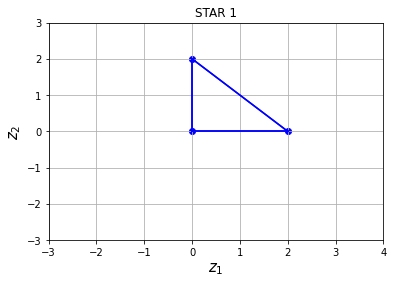

PREDICATE CONSTRAINTS:
+ 1.0 * x_0 + 0.0 * x_1 <= 1.0
- 1.0 * x_0 + 0.0 * x_1 <= 1.0
+ 0.0 * x_0 + 1.0 * x_1 <= 1.0
+ 0.0 * x_0 - 1.0 * x_1 <= 1.0
- 1.0 * x_0 - 1.0 * x_1 <= 0.0
- 1.0 * x_0 + 1.0 * x_1 <= 0.0
VARIABLES EQUATIONS:
z_0 = + 1.0 * x_0 + 1.0 * x_1 + 0.0
z_1 = + 1.0 * x_0 - 1.0 * x_1 + 0.0


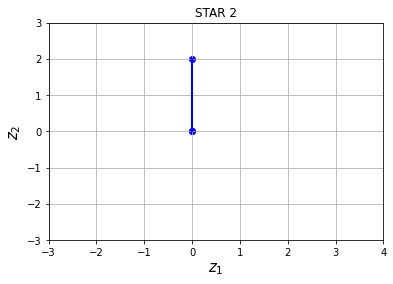

PREDICATE CONSTRAINTS:
+ 1.0 * x_0 + 0.0 * x_1 <= 1.0
- 1.0 * x_0 + 0.0 * x_1 <= 1.0
+ 0.0 * x_0 + 1.0 * x_1 <= 1.0
+ 0.0 * x_0 - 1.0 * x_1 <= 1.0
+ 1.0 * x_0 + 1.0 * x_1 <= -0.0
- 1.0 * x_0 + 1.0 * x_1 <= 0.0
VARIABLES EQUATIONS:
z_0 = + 0.0 * x_0 + 0.0 * x_1 + 0.0
z_1 = + 1.0 * x_0 - 1.0 * x_1 + 0.0


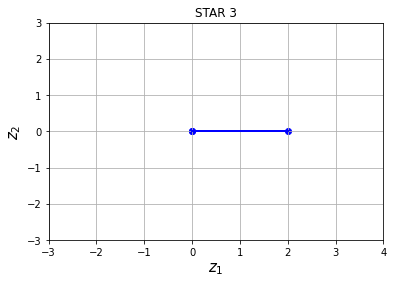

PREDICATE CONSTRAINTS:
+ 1.0 * x_0 + 0.0 * x_1 <= 1.0
- 1.0 * x_0 + 0.0 * x_1 <= 1.0
+ 0.0 * x_0 + 1.0 * x_1 <= 1.0
+ 0.0 * x_0 - 1.0 * x_1 <= 1.0
- 1.0 * x_0 - 1.0 * x_1 <= 0.0
+ 1.0 * x_0 - 1.0 * x_1 <= -0.0
VARIABLES EQUATIONS:
z_0 = + 1.0 * x_0 + 1.0 * x_1 + 0.0
z_1 = + 0.0 * x_0 + 0.0 * x_1 + 0.0

STARSET


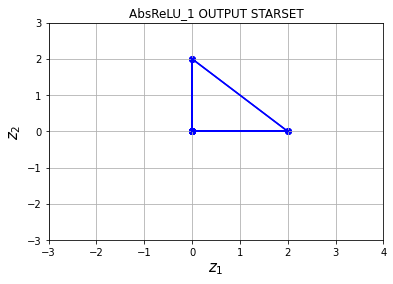

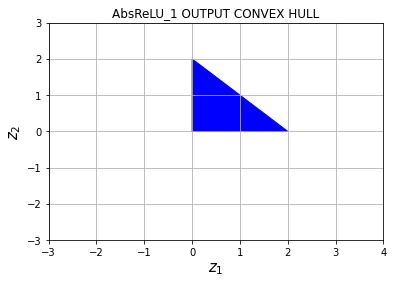

In [4]:
# FIRST ReLU NODE DEFINITION

current_node = abst.AbsReLUNode("AbsReLU_1", nodes.ReLUNode("ReLU_1", (2,)), "best_n_neurons", [n_ref_n])

# CORRESPONDING ABSTRACT OUTPUT COMPUTATION
abs_input = current_node.forward(abs_input)

# NODE VISUALIZATION
print(f"\n\nCURRENT NODE: {current_node.identifier}")

# STARS AND STARSET VISUALIZATION
print("\nSTARS")
n_star = 0
for star in abs_input.stars:
    plot_star(star, show=True, title=f"STAR {n_star}", color=fill_color)
    plt.xlim([-3,4])
    plt.ylim([-3,3])
    plt.xlabel("$z_1$", size=15)
    plt.ylabel("$z_2$", size=15)
    plt.savefig(f"overapproximate_{current_node.identifier}_STAR={n_star}.pdf")
    plt.show()
    print_star_data(star)
    n_star += 1

print("\nSTARSET")
plot_starset(abs_input, current_node.identifier + " OUTPUT STARSET", color=fill_color)
plt.xlim([-3,4])
plt.ylim([-3,3])
plt.xlabel("$z_1$", size=15)
plt.ylabel("$z_2$", size=15)
plt.show()
plot_convex_hull(get_starset_extreme_points(abs_input), 
                 current_node.identifier + " OUTPUT CONVEX HULL", color=fill_color)
plt.xlim([-3,4])
plt.ylim([-3,3])
plt.xlabel("$z_1$", size=15)
plt.ylabel("$z_2$", size=15)
plt.savefig(f"overapproximate_chull_{current_node.identifier}.pdf")
plt.show()
final_abstract_hulls.append(get_starset_extreme_points(abs_input))



CURRENT NODE: AbsFC_2
WEIGHTS: [[ 1.  1.]
 [ 1. -1.]]
BIAS: [0. 0.]

STARS


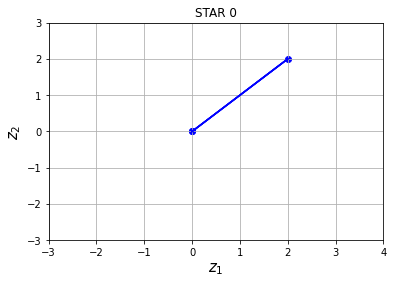

PREDICATE CONSTRAINTS:
+ 1.0 * x_0 + 0.0 * x_1 <= 1.0
- 1.0 * x_0 + 0.0 * x_1 <= 1.0
+ 0.0 * x_0 + 1.0 * x_1 <= 1.0
+ 0.0 * x_0 - 1.0 * x_1 <= 1.0
- 1.0 * x_0 - 1.0 * x_1 <= 0.0
+ 1.0 * x_0 - 1.0 * x_1 <= -0.0
VARIABLES EQUATIONS:
z_0 = + 1.0 * x_0 + 1.0 * x_1 + 0.0
z_1 = + 1.0 * x_0 + 1.0 * x_1 + 0.0


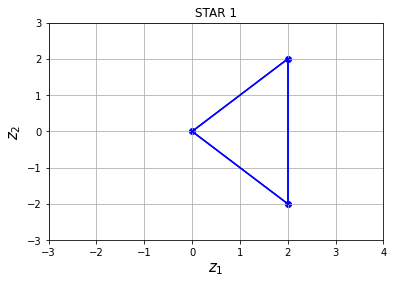

PREDICATE CONSTRAINTS:
+ 1.0 * x_0 + 0.0 * x_1 <= 1.0
- 1.0 * x_0 + 0.0 * x_1 <= 1.0
+ 0.0 * x_0 + 1.0 * x_1 <= 1.0
+ 0.0 * x_0 - 1.0 * x_1 <= 1.0
- 1.0 * x_0 - 1.0 * x_1 <= 0.0
- 1.0 * x_0 + 1.0 * x_1 <= 0.0
VARIABLES EQUATIONS:
z_0 = + 2.0 * x_0 + 0.0 * x_1 + 0.0
z_1 = + 0.0 * x_0 + 2.0 * x_1 + 0.0


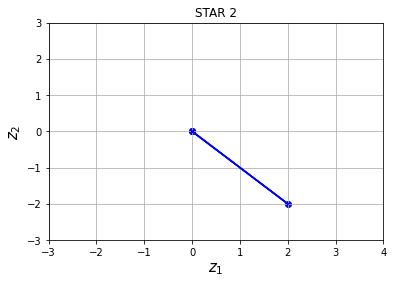

PREDICATE CONSTRAINTS:
+ 1.0 * x_0 + 0.0 * x_1 <= 1.0
- 1.0 * x_0 + 0.0 * x_1 <= 1.0
+ 0.0 * x_0 + 1.0 * x_1 <= 1.0
+ 0.0 * x_0 - 1.0 * x_1 <= 1.0
+ 1.0 * x_0 + 1.0 * x_1 <= -0.0
- 1.0 * x_0 + 1.0 * x_1 <= 0.0
VARIABLES EQUATIONS:
z_0 = + 1.0 * x_0 - 1.0 * x_1 + 0.0
z_1 = - 1.0 * x_0 + 1.0 * x_1 + 0.0


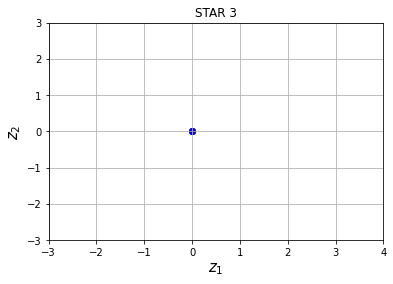

PREDICATE CONSTRAINTS:
+ 1.0 * x_0 + 0.0 * x_1 <= 1.0
- 1.0 * x_0 + 0.0 * x_1 <= 1.0
+ 0.0 * x_0 + 1.0 * x_1 <= 1.0
+ 0.0 * x_0 - 1.0 * x_1 <= 1.0
+ 1.0 * x_0 + 1.0 * x_1 <= -0.0
+ 1.0 * x_0 - 1.0 * x_1 <= -0.0
VARIABLES EQUATIONS:
z_0 = + 0.0 * x_0 + 0.0 * x_1 + 0.0
z_1 = + 0.0 * x_0 + 0.0 * x_1 + 0.0

STARSET


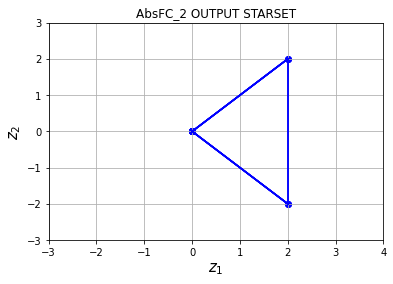

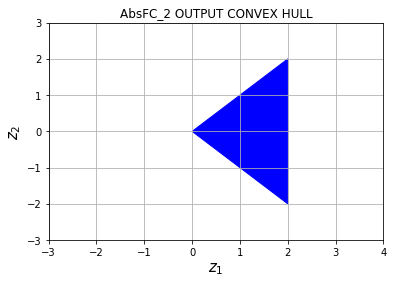

In [5]:
# SECOND FULLY CONNECTED NODE DEFINITION

weight_matrix_2 = np.ones((2, 2))
weight_matrix_2[1, 1] = -1
bias_2 = np.zeros(2)

current_node = abst.AbsFullyConnectedNode("AbsFC_2", nodes.FullyConnectedNode("FC_2", (2,), 2, weight_matrix_2, bias_2))

# CORRESPONDING ABSTRACT OUTPUT COMPUTATION
abs_input = current_node.forward(abs_input)

# NODE VISUALIZATION
print(f"\n\nCURRENT NODE: {current_node.identifier}")
print(f"WEIGHTS: {current_node.ref_node.weight}")
print(f"BIAS: {current_node.ref_node.bias}")

# STARS AND STARSET VISUALIZATION
print("\nSTARS")
n_star = 0
for star in abs_input.stars:
    plot_star(star, show=True, title=f"STAR {n_star}", color=fill_color)
    plt.xlim([-3,4])
    plt.ylim([-3,3])
    plt.xlabel("$z_1$", size=15)
    plt.ylabel("$z_2$", size=15)
    plt.savefig(f"overapproximate_{current_node.identifier}_STAR={n_star}.pdf")
    plt.show()
    print_star_data(star)
    n_star += 1

print("\nSTARSET")
plot_starset(abs_input, current_node.identifier + " OUTPUT STARSET", color=fill_color)
plt.xlim([-3,4])
plt.ylim([-3,3])
plt.xlabel("$z_1$", size=15)
plt.ylabel("$z_2$", size=15)
plt.show()
plot_convex_hull(get_starset_extreme_points(abs_input), 
                 current_node.identifier + " OUTPUT CONVEX HULL", color=fill_color)
plt.xlim([-3,4])
plt.ylim([-3,3])
plt.xlabel("$z_1$", size=15)
plt.ylabel("$z_2$", size=15)
plt.savefig(f"overapproximate_chull_{current_node.identifier}.pdf")
plt.show()
final_abstract_hulls.append(get_starset_extreme_points(abs_input))



CURRENT NODE: AbsReLU_2

STARS


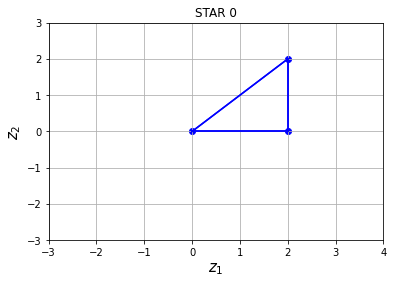

PREDICATE CONSTRAINTS:
+ 1.0 * x_0 + 0.0 * x_1 <= 1.0
- 1.0 * x_0 + 0.0 * x_1 <= 1.0
+ 0.0 * x_0 + 1.0 * x_1 <= 1.0
+ 0.0 * x_0 - 1.0 * x_1 <= 1.0
- 1.0 * x_0 - 1.0 * x_1 <= 0.0
- 1.0 * x_0 + 1.0 * x_1 <= 0.0
+ 0.0 * x_0 - 2.0 * x_1 <= 0.0
VARIABLES EQUATIONS:
z_0 = + 2.0 * x_0 + 0.0 * x_1 + 0.0
z_1 = + 0.0 * x_0 + 2.0 * x_1 + 0.0


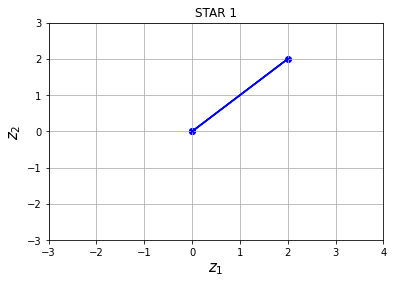

PREDICATE CONSTRAINTS:
+ 1.0 * x_0 + 0.0 * x_1 <= 1.0
- 1.0 * x_0 + 0.0 * x_1 <= 1.0
+ 0.0 * x_0 + 1.0 * x_1 <= 1.0
+ 0.0 * x_0 - 1.0 * x_1 <= 1.0
- 1.0 * x_0 - 1.0 * x_1 <= 0.0
+ 1.0 * x_0 - 1.0 * x_1 <= -0.0
VARIABLES EQUATIONS:
z_0 = + 1.0 * x_0 + 1.0 * x_1 + 0.0
z_1 = + 1.0 * x_0 + 1.0 * x_1 + 0.0


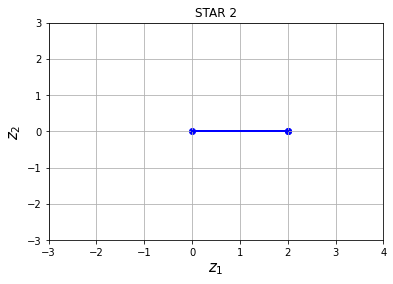

PREDICATE CONSTRAINTS:
+ 1.0 * x_0 + 0.0 * x_1 <= 1.0
- 1.0 * x_0 + 0.0 * x_1 <= 1.0
+ 0.0 * x_0 + 1.0 * x_1 <= 1.0
+ 0.0 * x_0 - 1.0 * x_1 <= 1.0
- 1.0 * x_0 - 1.0 * x_1 <= 0.0
- 1.0 * x_0 + 1.0 * x_1 <= 0.0
+ 0.0 * x_0 + 2.0 * x_1 <= -0.0
VARIABLES EQUATIONS:
z_0 = + 2.0 * x_0 + 0.0 * x_1 + 0.0
z_1 = + 0.0 * x_0 + 0.0 * x_1 + 0.0


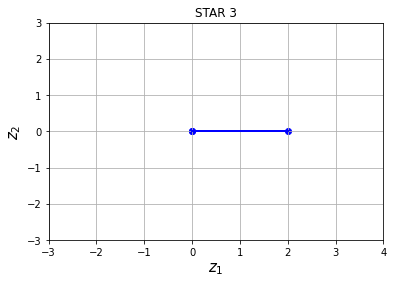

PREDICATE CONSTRAINTS:
+ 1.0 * x_0 + 0.0 * x_1 <= 1.0
- 1.0 * x_0 + 0.0 * x_1 <= 1.0
+ 0.0 * x_0 + 1.0 * x_1 <= 1.0
+ 0.0 * x_0 - 1.0 * x_1 <= 1.0
+ 1.0 * x_0 + 1.0 * x_1 <= -0.0
- 1.0 * x_0 + 1.0 * x_1 <= 0.0
VARIABLES EQUATIONS:
z_0 = + 1.0 * x_0 - 1.0 * x_1 + 0.0
z_1 = + 0.0 * x_0 + 0.0 * x_1 + 0.0


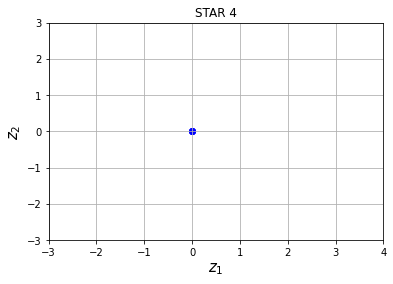

PREDICATE CONSTRAINTS:
+ 1.0 * x_0 + 0.0 * x_1 <= 1.0
- 1.0 * x_0 + 0.0 * x_1 <= 1.0
+ 0.0 * x_0 + 1.0 * x_1 <= 1.0
+ 0.0 * x_0 - 1.0 * x_1 <= 1.0
+ 1.0 * x_0 + 1.0 * x_1 <= -0.0
+ 1.0 * x_0 - 1.0 * x_1 <= -0.0
VARIABLES EQUATIONS:
z_0 = + 0.0 * x_0 + 0.0 * x_1 + 0.0
z_1 = + 0.0 * x_0 + 0.0 * x_1 + 0.0

STARSET


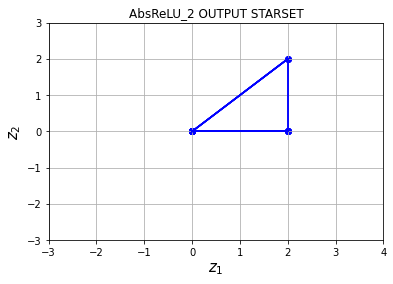

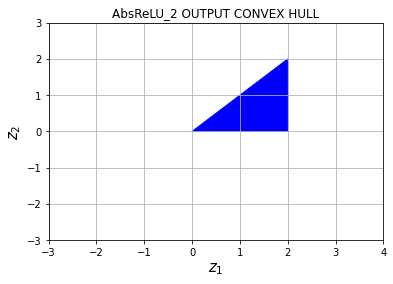

In [6]:
# SECOND ReLU NODE DEFINITION

current_node = abst.AbsReLUNode("AbsReLU_2", nodes.ReLUNode("ReLU_2", (2,)), "best_n_neurons", [n_ref_n])

# CORRESPONDING ABSTRACT OUTPUT COMPUTATION
abs_input = current_node.forward(abs_input)

# NODE VISUALIZATION
print(f"\n\nCURRENT NODE: {current_node.identifier}")

# STARS AND STARSET VISUALIZATION
print("\nSTARS")
n_star = 0
for star in abs_input.stars:
    plot_star(star, show=True, title=f"STAR {n_star}", color=fill_color)
    plt.xlim([-3,4])
    plt.ylim([-3,3])
    plt.xlabel("$z_1$", size=15)
    plt.ylabel("$z_2$", size=15)
    plt.savefig(f"overapproximate_{current_node.identifier}_STAR={n_star}.pdf")
    plt.show()
    print_star_data(star)
    n_star += 1
    
print("\nSTARSET")
plot_starset(abs_input, current_node.identifier + " OUTPUT STARSET", color=fill_color)
plt.xlim([-3,4])
plt.ylim([-3,3])
plt.xlabel("$z_1$", size=15)
plt.ylabel("$z_2$", size=15)
plt.show()
plot_convex_hull(get_starset_extreme_points(abs_input), 
                 current_node.identifier + " OUTPUT CONVEX HULL", color=fill_color)
plt.xlim([-3,4])
plt.ylim([-3,3])
plt.xlabel("$z_1$", size=15)
plt.ylabel("$z_2$", size=15)
plt.savefig(f"overapproximate_chull_{current_node.identifier}.pdf")
plt.show()
final_abstract_hulls.append(get_starset_extreme_points(abs_input))

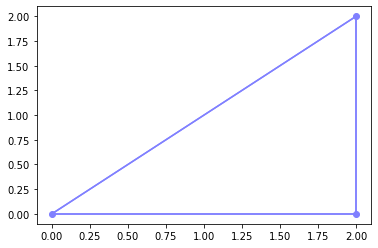

[[0. 1.]
 [0. 0.]]
[[0.5]
 [0. ]]


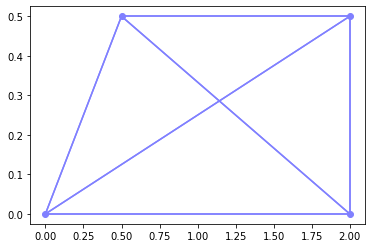

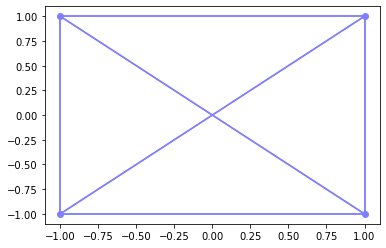

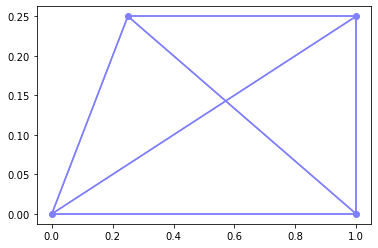

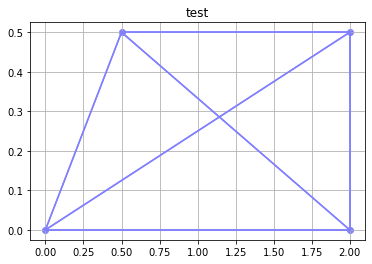

In [46]:
full_star = list(abs_input.stars)[0]
plot_star(full_star)
plt.show()
half_mat = np.zeros((2, 2))
half_mat[0, 1] = 1
half_mat[1, 0] = 0
half_bias = np.zeros((2, 1))
half_bias[0] = 0.5
half_bias[1] = 0
print(half_mat)
print(half_bias)
temp_star = abst.intersect_with_halfspace(full_star, half_mat, half_bias)
plot_star(temp_star)
plt.show()

# INPUT STARSET DEFINITION
C = np.zeros((4, 2))
C[0, 0] = 1
C[1, 0] = -1
C[2, 1] = 1
C[3, 1] = -1

d = np.ones((4, 1))
d[0, 0] = 1
d[1, 0] = 1
d[2, 0] = 1
d[3, 0] = 1

in_star = abst.Star(C, d)
plot_star(in_star)
plt.show()

counter_star = abst.Star(temp_star.predicate_matrix, temp_star.predicate_bias)
plot_star(counter_star)
plt.show()

weight_matrix_1 = np.ones((2, 2))
weight_matrix_2 = np.ones((2, 2))

weight_matrix_1[1, 1] = -1
weight_matrix_2[1, 1] = -1

bias_1 = np.zeros(2)
bias_2 = np.zeros(2)

##################################

abs_net_0000 = abst.AbsSeqNetwork("Over-approximate Net")

abs_net_0000.add_node(
    abst.AbsFullyConnectedNode("AbsFC_1", nodes.FullyConnectedNode("FC_1", (2,), 2, weight_matrix_1, bias_1)))

abs_net_0000.add_node(abst.AbsReLUNode("AbsReLU_1", nodes.ReLUNode("ReLU_1", (2,)), "best_n_neurons", [10]))

abs_net_0000.add_node(
    abst.AbsFullyConnectedNode("AbsFC_2", nodes.FullyConnectedNode("FC_2", (2,), 2, weight_matrix_2, bias_2)))

abs_net_0000.add_node(abst.AbsReLUNode("AbsReLU_2", nodes.ReLUNode("ReLU_2", (2,)), "best_n_neurons", [10]))

in_starset = abst.StarSet({counter_star})
out_starset = abs_net_0000.forward(in_starset)
plot_starset(out_starset, "test")
plt.show()